In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm

In [3]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import get_linear_schedule_with_warmup

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
model_name = "xlnet-base-cased"

# Load tokenizer
tokenizer = XLNetTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [6]:
excelpath = "/content/drive/My Drive/Colab/AS4/STEP1-data_prepare/final_labeled_dataset.xlsx"

df = pd.read_excel(excelpath)

In [9]:
df['num_label'] = pd.factorize(df['Label'])[0]
df = df.drop('Label', axis=1)

In [10]:
num_folds = 10
batch_size = 16

In [18]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['Text'].tolist()
        self.labels = dataframe['num_label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=101,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [19]:
def train_model(train_loader, model, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    return total_loss / len(train_loader)


In [20]:
from torch.nn.functional import softmax

# Evaluation function
def evaluate_model(test_loader, model, device):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []  # To store class probabilities
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            # Get predicted class (for accuracy, etc.)
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            # Get probabilities for each class
            batch_probs = softmax(logits, dim=1).cpu().numpy()

            predictions.extend(batch_preds)
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(batch_probs)  # Store probabilities

    return {
        'loss': total_loss / len(test_loader),
        'accuracy': accuracy_score(true_labels, predictions),
        'f1': f1_score(true_labels, predictions, average='weighted'),
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities  # Add probabilities to return dict
    }

In [21]:
def classify_text(text, model, tokenizer, device, class_names=None):
    # Set model to evaluation mode
    model.eval()

    # Tokenize the input text
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=100,
        return_tensors='pt'
    )

    # Move tensors to the device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    confidence, predicted_class = torch.max(probabilities, dim=1)

    # Convert to numpy/cpu
    confidence = confidence.cpu().numpy()[0]
    predicted_class = predicted_class.cpu().numpy()[0]
    all_confidences = probabilities.cpu().numpy()[0]

    # Prepare output
    result = {
        'predicted_class': predicted_class,
        'confidence': float(confidence),
        'all_confidences': [float(x) for x in all_confidences],
        'raw_output': outputs.logits.cpu().numpy()[0]
    }

    # Add class names if provided
    if class_names is not None and len(class_names) > predicted_class:
        result['predicted_class_name'] = class_names[predicted_class]
        result['all_class_confidences'] = {
            class_name: float(conf)
            for class_name, conf in zip(class_names, all_confidences)
        }

    return result

In [22]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 3. ROC-AUC (Multiclass)
def plot_multiclass_roc(model, dataloader, device, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items()
                     if k in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Binarize the labels
    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [23]:
dataset = TextDataset(df)
class_names = df['num_label'].unique()
train_whole, test_whole = train_test_split(dataset, test_size=0.1)
all_indices = np.arange(len(train_whole))

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40
Train Loss: 1.0981
Val Loss: 0.5559
Val Accuracy: 0.8222
Val F1: 0.8208
----------
Epoch 2/40
Train Loss: 0.4431
Val Loss: 0.4746
Val Accuracy: 0.8444
Val F1: 0.8421
----------
Epoch 3/40
Train Loss: 0.2223
Val Loss: 0.4630
Val Accuracy: 0.8667
Val F1: 0.8672
----------
Epoch 4/40
Train Loss: 0.1232
Val Loss: 0.4900
Val Accuracy: 0.8889
Val F1: 0.8886
----------
Epoch 5/40
Train Loss: 0.0566
Val Loss: 0.5713
Val Accuracy: 0.9000
Val F1: 0.8970
----------
Epoch 6/40
Train Loss: 0.0205
Val Loss: 0.5445
Val Accuracy: 0.9111
Val F1: 0.9118
----------
Epoch 7/40
Train Loss: 0.0337
Val Loss: 0.7407
Val Accuracy: 0.8778
Val F1: 0.8782
----------
Epoch 8/40
Train Loss: 0.0091
Val Loss: 0.6733
Val Accuracy: 0.9111
Val F1: 0.9079
----------
Epoch 9/40
Train Loss: 0.0109
Val Loss: 0.7894
Val Accuracy: 0.8778
Val F1: 0.8772
----------
Epoch 10/40
Train Loss: 0.0129
Val Loss: 0.6340
Val Accuracy: 0.9000
Val F1: 0.8990
----------
Epoch 11/40
Train Loss: 0.0107
Val Loss: 0.7961
Val Accurac

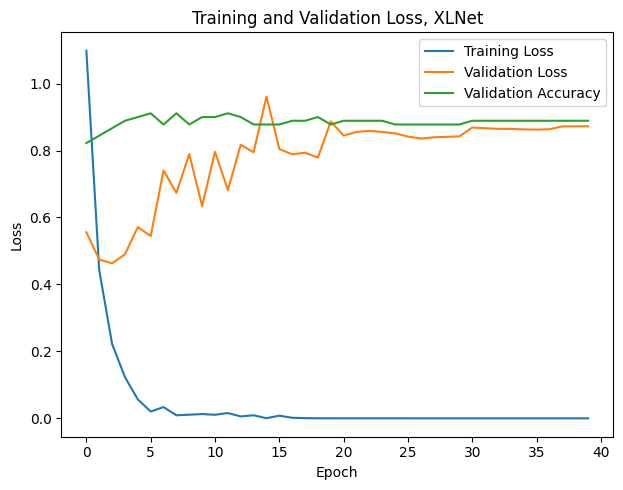

In [ ]:
#DETERMINE EPOCHS FOR CONVERGENCE

import matplotlib.pyplot as plt
epochs = 40

train1, test1 = train_test_split(train_whole, test_size=0.1)
all_indices = np.arange(len(train1))

train1_loader = DataLoader(train1, batch_size=batch_size, shuffle=True)
test1_loader = DataLoader(test1, batch_size=batch_size)

model_actual = XLNetForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5
    ).to(device)

train_losses = []
eval_losses = []
eval_accuracies = []

optimizer = AdamW(model_actual.parameters(), lr=2e-5)
total_steps = len(train1_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

    # Training loop
for epoch in range(epochs):
    train_loss = train_model(train1_loader, model_actual, optimizer, scheduler, device)
    eval_results = evaluate_model(test1_loader, model_actual, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {eval_results['loss']:.4f}")
    print(f"Val Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Val F1: {eval_results['f1']:.4f}")
    print("-" * 10)

    train_losses.append(train_loss)
    eval_losses.append(eval_results['loss'])
    eval_accuracies.append(eval_results['accuracy'])



plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.plot(eval_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Loss, XLNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
epochs = 35
num_folds = 10
all_true_labels = []
all_predictions = []
all_probabilities = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Main training loop with K-Fold CV
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n=== Fold {fold + 1}/{num_folds} ===")

    # Create train and validation datasets
    train_subset = Subset(train_whole, train_idx)
    val_subset = Subset(train_whole, val_idx)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    # Initialize model for each fold
    model = XLNetForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5
    ).to(device)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Training loop
    for epoch in range(epochs):
        train_loss = train_model(train_loader, model, optimizer, scheduler, device)
        eval_results = evaluate_model(val_loader, model, device)

        # print(f"Epoch {epoch + 1}/{epochs}")
        # print(f"Train Loss: {train_loss:.4f}")
        # print(f"Val Loss: {eval_results['loss']:.4f}")
        # print(f"Val Accuracy: {eval_results['accuracy']:.4f}")
        # print(f"Val F1: {eval_results['f1']:.4f}")
        # print("-" * 50)

    # Store fold results
    fold_results.append(eval_results)
    all_true_labels.extend(eval_results['true_labels'])
    all_predictions.extend(eval_results['predictions'])
    all_probabilities.extend(eval_results['probabilities'])

    # Print classification report for the fold
    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(
        eval_results['true_labels'],
        eval_results['predictions']
    ))

# Print overall results
print("\n=== Final Results ===")
accuracies = [result['accuracy'] for result in fold_results]
f1_scores = [result['f1'] for result in fold_results]

print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print("\nDetailed Metrics per Fold:")
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1}: Accuracy = {result['accuracy']:.4f}, F1 = {result['f1']:.4f}")


=== Fold 1/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.93      0.93      0.93        15
           2       0.94      0.83      0.88        18
           3       0.95      0.95      0.95        19
           4       0.93      0.93      0.93        15

    accuracy                           0.92        90
   macro avg       0.93      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90


=== Fold 2/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       1.00      0.90      0.95        20
           2       0.89      1.00      0.94        17
           3       0.94      0.94      0.94        18
           4       0.93      0.88      0.90        16

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90


=== Fold 3/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 3:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       0.86      0.75      0.80        16
           2       0.64      1.00      0.78        14
           3       0.93      0.76      0.84        17
           4       0.84      0.84      0.84        19

    accuracy                           0.84        90
   macro avg       0.85      0.85      0.84        90
weighted avg       0.87      0.84      0.85        90


=== Fold 4/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 4:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.77      0.87        22
           2       0.96      1.00      0.98        23
           3       0.87      0.95      0.91        21
           4       0.92      0.92      0.92        13

    accuracy                           0.92        90
   macro avg       0.92      0.93      0.92        90
weighted avg       0.93      0.92      0.92        90


=== Fold 5/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 5:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       1.00      0.78      0.88        18
           2       0.90      1.00      0.95        19
           3       0.89      0.89      0.89        18
           4       0.88      1.00      0.93        14

    accuracy                           0.91        90
   macro avg       0.91      0.91      0.91        90
weighted avg       0.92      0.91      0.91        90


=== Fold 6/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 6:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        27
           1       1.00      0.73      0.84        11
           2       0.88      0.93      0.90        15
           3       0.80      1.00      0.89        12
           4       0.96      0.88      0.92        25

    accuracy                           0.91        90
   macro avg       0.91      0.90      0.90        90
weighted avg       0.92      0.91      0.91        90


=== Fold 7/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 7:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.89      0.85      0.87        20
           2       0.95      0.90      0.93        21
           3       0.86      0.86      0.86        14
           4       0.91      0.95      0.93        22

    accuracy                           0.90        90
   macro avg       0.89      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90


=== Fold 8/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 8:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.94      0.94      0.94        18
           2       0.95      0.95      0.95        20
           3       1.00      0.93      0.96        14
           4       1.00      0.95      0.98        22

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90


=== Fold 9/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 9:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.85      0.85      0.85        13
           2       0.83      0.88      0.86        17
           3       0.96      0.92      0.94        24
           4       0.91      0.91      0.91        23

    accuracy                           0.90        90
   macro avg       0.89      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90


=== Fold 10/10 ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report for Fold 10:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.71      0.81      0.76        21
           2       0.93      0.82      0.88        17
           3       0.94      0.81      0.87        21
           4       0.76      0.93      0.84        14

    accuracy                           0.86        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.87      0.86      0.86        90


=== Final Results ===
Average Accuracy: 0.9056 ± 0.0319
Average F1 Score: 0.9059 ± 0.0306

Detailed Metrics per Fold:
Fold 1: Accuracy = 0.9222, F1 = 0.9218
Fold 2: Accuracy = 0.9333, F1 = 0.9333
Fold 3: Accuracy = 0.8444, F1 = 0.8483
Fold 4: Accuracy = 0.9222, F1 = 0.9207
Fold 5: Accuracy = 0.9111, F1 = 0.9096
Fold 6: Accuracy = 0.9111, F1 = 0.9102
Fold 7: Accuracy = 0.9000, F1 = 0.8999
Fold 8: Accuracy = 0.9556, F1 = 0.9559
Fold 9: Accuracy = 0.9000, F1 = 0.9004
Fold 